<a href="https://colab.research.google.com/github/iyzg/bytesofpi/blob/main/notebooks/minimal_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A Minimal MLP**<br/>
*Ivy Zhang, 2024*

For anyone who has some very basics in understanding neural networks, this is a little notebook to help translate what you've learned into real code! If you haven't learned too much about neural networksyet, then I recommend you check out these resources before going through this notebook:

- [Micrograd by Andrej Karpathy](https://www.youtube.com/watch?v=VMj-3S1tku0) (If nothing else, you should watch this)
- [Neural Networks & Deep Learning by Michael Nielsen](http://neuralnetworksanddeeplearning.com/)

By the end of this notebook, you'll have a neural network that can learn to identify numbers along with a basic framework for writing your own neural networks. I've bolded **important terms**.

> Note: You should run the cells here with at least a T4 GPU to speed things up.

In [ ]:
# @title Imports
from torch.utils.data       import DataLoader
from torchvision.datasets   import MNIST
from torchvision.transforms import ToTensor

import math
import matplotlib.pyplot    as plt
import numpy                as np
import random
import torch
import torch.nn             as nn
import torch.nn.functional  as F

In [ ]:
# @title Load training data
training_data = MNIST(root='.', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='.', train=False, download=True, transform=ToTensor())

In [ ]:
# @title Helper function
def view_sample(n_imgs, model=None, data=training_data):
    figure = plt.figure(layout='tight')
    rows = 3
    cols = math.ceil(n_imgs / rows)

    for i in range(1, n_imgs + 1):
        # Pull a random image from training set
        idx = random.randint(0, len(data))
        img, label = data[idx]

        figure.add_subplot(rows, cols, i)
        plt.axis('off')
        plt.title(f'Label: {label}' + (f', Pred: {torch.argmax(model(img.reshape(-1, 28*28).to(device)))}' if model else ''))
        plt.imshow(img.squeeze(), cmap='gray')
    plt.show()


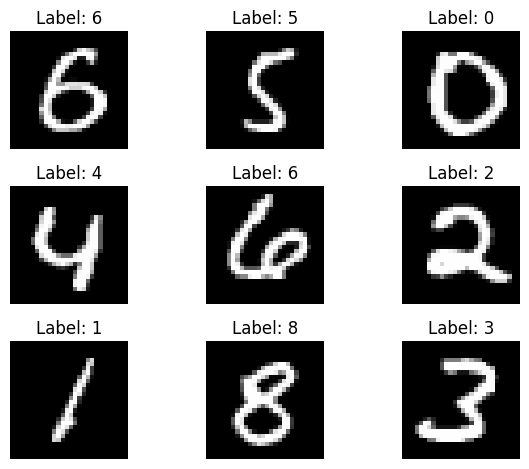

In [ ]:
view_sample(9)

Here we can see a sample of the numbers. They are 28x28 pixels and are black and white so their values from from 0 - 1.

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        self.blocks = []
        n = len(layers)
        for i in range(1, n):
            self.blocks.append(nn.Linear(layers[i-1], layers[i]))
            # Add a nonlinearity between all layers
            if i != n-1:
                self.blocks.append(nn.ReLU())

        self.net = nn.Sequential(*self.blocks)

    def forward(self, x):
        x = x.reshape(-1, 28*28)    # [b, 1, 28, 28] => [b, 784]
        return self.net(x)

shapes at 24-01-01 10.42.20.svg

At it's core, all neural networks in Pytorch come from this `nn.Module` class! The two most basic methods which you'll almost always need are an `__init__()` and a `forward()`. The init is what is called when you create the model, and forward is how you pass inputs through the model. Since we just have one way to pass messages through the network, I've used a `nn.Sequential` which lets you put multiple layers together.



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleNN([28*28, 64, 10]).to(device)     # [in_dim, hidden_dim, out_dim]
optimizer = torch.optim.AdamW(model.parameters())

The two necessary and most basic components to training your model are your model and an optimizer. The model is the neural network which will make predictions, and your optimizer is what updates your model weights after each batch of inputs. If you've gone through the linked tutorials, you might notice that none of them mention this "optimizer" as a core component since you can just adjust each weight by the gradient, but having something which adjusts the learning rate automatically helps us converge quicker.

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)       # Don't need shuffling for test

Even though we've already loaded in our data, PyTorch has a custom `DataLoader` that helps us automatically shuffle and batch our data.

Given a dataset, you usually train for multiple **epochs**. In every epoch, the model will see each input/output once. We seperate the data into **batches/mini-batches** of chunks of data since we can't load all 60,000 images to the GPU. The term **stochastic gradient descent (SGD)** comes from the fact we are always training on a *stochastic* gradient of a subset of the data.

> If we found the gradient from *every* datapoint all at once, this would just be **gradient descent (GD)**.


In [ ]:
# @title Training loop

EPOCHS = 10

for epoch in range(EPOCHS):
    losses = []

    # Training loop
    for batch in train_dataloader:
        x, y = batch

        # Your model and tensors have to be on the same device
        x, y = x.to(device), y.to(device)

        out = model(x)                  # Get model prediction from input

        loss = F.cross_entropy(out, y)  # Calculate the "loss" or how off you are
        optimizer.zero_grad()           # Zero out previous gradients
        loss.backward()                 # Backpropogate the new gradients
        optimizer.step()                # Update weights based on new gradients
        losses.append(loss.item())

    # Validation loop
    correct, total = 0, 0

    for batch in test_dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        out = model(x)
        _, idx = torch.max(out, dim=1)
        correct += torch.sum(idx == y)
        total += len(x)


    # Print out results
    print(f' epoch {epoch + 1:3d} \t loss {sum(losses) / len(losses):.3f} \t acc {correct / total * 100:.3f}%')

 epoch   1 	 loss 0.389 	 acc 93.840%
 epoch   2 	 loss 0.187 	 acc 95.570%
 epoch   3 	 loss 0.140 	 acc 95.990%
 epoch   4 	 loss 0.113 	 acc 96.540%
 epoch   5 	 loss 0.093 	 acc 96.910%
 epoch   6 	 loss 0.080 	 acc 97.060%
 epoch   7 	 loss 0.070 	 acc 97.140%
 epoch   8 	 loss 0.061 	 acc 97.140%
 epoch   9 	 loss 0.054 	 acc 97.270%
 epoch  10 	 loss 0.049 	 acc 97.300%


The main training loop has a few steps:

1. `model(x)`: Make predictions on our batch of inputs (syntactic sugar for `model.forward(x)`)
2. `loss = F.cross_entropy(out, y)`: Calculate a loss (how far off your prediction was)
3. `optimizer.zero_grad()`: Zero out previous gradient
4. `loss.backward()`: Backpropogate the gradient
5. `optimizer.step()`: Update weights based on gradient

> **IMPORTANT:** Don't forget to zero out the gradients in your own training loops before backpropogating. We have to do this since our gradients accumulate, so backpropogating _will not_ zero out gradients automatically.

I've also included a simple validation inside our training loop so we can see how our accuracy is doing.

Let's see how our model is performing now!

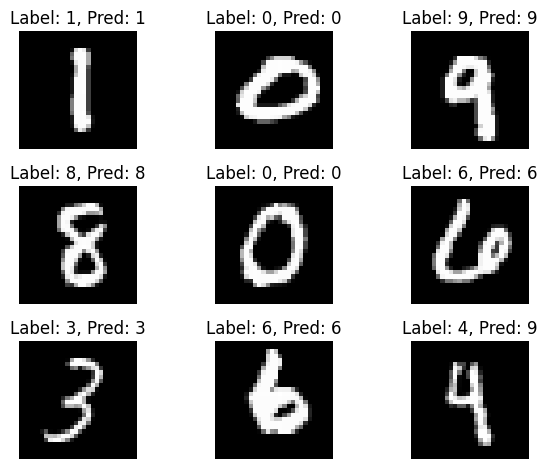

In [ ]:
view_sample(9, model, test_data)

Just for simple things to add, you should look into adding some data augmentation and CNN (this should boost you up to high 99% accuracy), but I'll leave that as an exercise to the reader. Hopefully this helps someone get a basic grasp of how Pytorch neural networks are structured